Building the Master Project Dataset
===

In [1]:
import numpy as np
import goldsberry
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option("display.max_columns",50) # Change Pandas Display Options
%matplotlib inline
goldsberry.__version__

'1.0.1'

In [2]:
gameids = goldsberry.GameIDs(Season='2014-15')
gameids = pd.DataFrame(gameids.game_list())
gameids.head(5)
# gameids2015.columns.values
# convert to datetime
date_cols = ['GAME_DATE']
for col in date_cols:
    gameids[col] = pd.to_datetime(gameids[col])

gameids[gameids['GAME_ID']==gameids['GAME_ID'].iloc[0]]
# list(gameids2015)

,AST,BLK,DREB,FG3A,FG3M,FG3_PCT,FGA,FGM,FG_PCT,FTA,FTM,FT_PCT,GAME_DATE,GAME_ID,MATCHUP,MIN,OREB,PF,PLUS_MINUS,PTS,REB,SEASON_ID,STL,TEAM_ABBREVIATION,TEAM_ID,TEAM_NAME,TOV,VIDEO_AVAILABLE,WL
0,39,6,38,29,11,0.379,109,57,0.523,24,19,0.792,2015-04-10,0021401184,DAL @ DEN,290,11,23,1,144,49,22014,8,DAL,1610612742,Dallas Mavericks,17,1,W
3,29,1,34,43,15,0.349,125,53,0.424,25,22,0.880,2015-04-10,0021401184,DEN vs. DAL,290,27,26,-1,143,61,22014,10,DEN,1610612743,Denver Nuggets,15,1,L


In [3]:
# Create a new dataframe with home team and away team stats
games = pd.DataFrame(columns=[colname+'_HOME' for colname in gameids.columns] + \
                                  [colname+'_AWAY' for colname in gameids.columns],
                    index=gameids['GAME_ID'].unique())

# Then, for each GAME_ID, fill in both the home team and away team stats.
# First, loop over the GAME_IDs
for i, gid in enumerate(gameids['GAME_ID'].unique()):
    # first, find home team
    home_data = gameids[(gameids['GAME_ID']==gid) & (gameids['MATCHUP'].str.contains('vs.'))]
    away_data = gameids[(gameids['GAME_ID']==gid) & (gameids['MATCHUP'].str.contains('@'))]
    for colname in gameids.columns:
        games.ix[gid][colname+'_HOME'] = home_data[colname].values[0]
        games.ix[gid][colname+'_AWAY'] = away_data[colname].values[0]

In [4]:
# The target for each game will be the winner (abbreviation) and the point differential
# This tells us if hte home team won (positive) or lost (negative) and by how much.    
games['point_spread'] = games['PLUS_MINUS_HOME']

In [5]:
# Construct features

# Given a point in time, calculate relevant quantities for the home and away teams in each game
# For example, 1. Field goal percentage, 2. 3-point percentage, 3. Free throw percentage, 4. Number of fouls
def cumulative_percent(date, team_name, attempt_col_name, total_col_name):
    # maybe convert to datetime object
    game_data = gameids[(gameids.GAME_DATE < date) & (gameids.TEAM_ABBREVIATION == team_name)]
    #print game_data
    made = game_data[attempt_col_name].astype(float).sum()
    att = game_data[total_col_name].astype(float).sum()
    return made/att if att !=0 else np.nan

def cumulative_mean(date, team_name, total_col_name):
    # maybe convert to datetime object
    game_data = gameids[(gameids.GAME_DATE < date) & (gameids.TEAM_ABBREVIATION == team_name)]
    #print game_data
    return game_data[total_col_name].astype(float).mean()


In [6]:
# CREATE STATISTICS TABLE
# Create a lookup table for all the teams' cumulative stats for every date.
# Create a dictionary of DataFrames
gameids_srt = gameids.sort_values(by='GAME_DATE')
gameids_srt['GAME_COUNT'] = 1

all_stats = gameids_srt.groupby(['TEAM_ABBREVIATION','GAME_DATE','GAME_ID']).sum().groupby(level=[0]).cumsum()
# Add GAME_ID as a column instead of an index
all_stats.loc[(slice(None),slice(None))].reset_index(level='GAME_ID',inplace=True)
#all_stats.loc['ATL']

In [7]:
# Calculate the statistics after DataFrame has been created
# Indexed by (Team Abbrev., Date (as a datetime object))
pct_columns = ['FG','FG3','FT']  # ==> Total Made/Total Attempted 
avg_columns = ['AST','BLK','DREB','OREB','PF','REB','STL','TOV','FGA',"FGM",'FG3A',"FG3M",'FTA','FTM','PLUS_MINUS'] # ==> Moving Average for game n (Game 1->Game 1-n)

team_abbrvs = all_stats.index.levels[0]

# Loop over all teams
for team in team_abbrvs:
    for col in avg_columns: # running average
        all_stats.loc[(team, slice(None)),col+'_mean'] = all_stats.loc[(team, slice(None)),col] / all_stats.loc[(team, slice(None)),'GAME_COUNT']
    for col in pct_columns: # made/attempted
        all_stats.loc[(team, slice(None)),col+'_pct'] = all_stats.loc[(team, slice(None)), col+'M'] / all_stats.loc[(team, slice(None)), col+'A']

# Example output
# all_stats.loc['ATL']

In [ ]:
all_stats.loc[('OKC',slice(None))]

In [69]:
# For example, get a date range
# all_stats.loc['ATL'].loc['2015-10-31': '2015-11-30']

In [11]:
games['FG_PCT_HOME'].hist(label='FG', alpha=0.5)
games['FG3_PCT_HOME'].hist(label='FG3',alpha=0.5)
games['FT_PCT_HOME'].hist(label='FT',alpha=0.5)

plt.legend()

In [15]:
for col in totals_columns:
    games[col+'_HOME'].hist(label=col, alpha=0.25)
plt.legend()

In [16]:
from sklearn.preprocessing import StandardScaler
# Can scale teh columns in percent_columns.keys() + '_HOME' or '_AWAY' using StandardScaler


(0, 1.0)

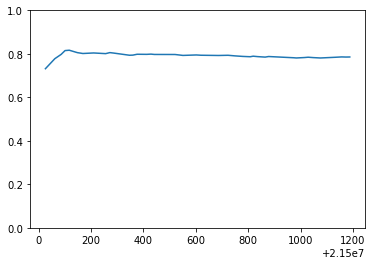

In [17]:
%matplotlib inline
plt.plot(games[games['TEAM_ABBREVIATION_HOME'] == 'ATL'].sort_values(by='GAME_DATE_HOME')['CumulFT_HOME'])
plt.ylim(0,1.0)

In [18]:
games.head()

,AST_HOME,BLK_HOME,DREB_HOME,FG3A_HOME,FG3M_HOME,FG3_PCT_HOME,FGA_HOME,FGM_HOME,FG_PCT_HOME,FTA_HOME,FTM_HOME,FT_PCT_HOME,GAME_DATE_HOME,GAME_ID_HOME,MATCHUP_HOME,MIN_HOME,OREB_HOME,PF_HOME,PLUS_MINUS_HOME,PTS_HOME,REB_HOME,SEASON_ID_HOME,STL_HOME,TEAM_ABBREVIATION_HOME,TEAM_ID_HOME,...,VIDEO_AVAILABLE_AWAY,WL_AWAY,point_spread,CumulFG3_HOME,CumulFG3_AWAY,CumulFG_HOME,CumulFG_AWAY,CumulFT_HOME,CumulFT_AWAY,CumulAST_HOME,CumulAST_AWAY,CumulBLK_HOME,CumulBLK_AWAY,CumulDREB_HOME,CumulDREB_AWAY,CumulOREB_HOME,CumulOREB_AWAY,CumulPF_HOME,CumulPF_AWAY,CumulREB_HOME,CumulREB_AWAY,CumulSTL_HOME,CumulSTL_AWAY,CumulTOV_HOME,CumulTOV_AWAY
0021501226,41,8,38,28,13,0.464,86,56,0.651,23,19,0.826,2016-04-13T00:00:00.000000000,0021501226,MIN vs. NOP,240,5,20,35,144,43,22015,14,MIN,1610612750,...,1,L,35,0.335102,0.359708,0.461714,0.448043,0.791781,0.775680,23.148148,22.061728,4.530864,4.222222,31.469136,33.197531,10.074074,9.530864,20.691358,20.950617,41.543210,42.728395,7.925926,7.728395,15.037037,13.407407
0021501108,40,5,30,27,14,0.519,91,56,0.615,19,13,0.684,2016-03-29T00:00:00.000000000,0021501108,ORL vs. BKN,240,5,29,34,139,35,22015,11,ORL,1610612753,...,1,L,34,0.348253,0.355814,0.448918,0.458928,0.761480,0.767893,23.150685,22.191781,4.972603,3.945205,33.301370,32.068493,10.506849,10.123288,20.794521,17.986301,43.808219,42.191781,8.082192,7.493151,14.260274,14.876712
0021500391,21,9,42,22,5,0.227,120,50,0.417,44,39,0.886,2015-12-18T00:00:00.000000000,0021500391,CHI vs. DET,340,20,35,-3,144,62,22015,5,CHI,1610612741,...,1,W,-3,0.366864,0.329513,0.424938,0.425263,0.756917,0.667651,22.608696,18.074074,6.130435,3.444444,38.304348,33.703704,10.391304,13.444444,18.608696,18.814815,48.695652,47.148148,6.565217,8.407407,14.391304,14.259259
0021500855,23,4,29,26,10,0.385,90,41,0.456,28,22,0.786,2016-02-25T00:00:00.000000000,0021500855,ORL vs. GSW,240,8,17,-16,114,37,22015,11,ORL,1610612753,...,1,W,-16,0.353420,0.418699,0.448588,0.486680,0.770104,0.757198,23.109091,29.035714,5.036364,6.107143,33.600000,36.339286,10.545455,10.285714,20.254545,20.821429,44.145455,46.625000,8.054545,8.339286,14.654545,15.303571
0021500496,30,2,36,23,9,0.391,87,53,0.609,34,27,0.794,2016-01-02T00:00:00.000000000,0021500496,SAC vs. PHX,240,10,23,23,142,46,22015,9,SAC,1610612758,...,1,L,23,0.360324,0.379233,0.454711,0.448517,0.715550,0.748362,24.218750,20.571429,4.000000,3.828571,33.593750,32.571429,10.625000,10.600000,20.906250,21.457143,44.218750,43.171429,8.312500,9.000000,16.843750,16.857143


Like the PlayerList() class, the GameIDs() class defaults to the current season. If we want the 2006-07 season, we need to identify and change the proper parameters. We can see the available parameters to set by printing the `api_params` attribute.

From there, we can see we should set the `Season` value to `2006-07`. Once we set the parameter, we need to get new data and then save the new data as a data frame to a new object.

In [ ]:
gameids.get_new_data(Season='2016-17',PlayerOrTeam = "T")
gameids._set_api_parameters(Sorter = "GAME_DATE")
gameids2017 = pd.DataFrame(gameids.game_list())
gameids2017.head()["GAME_DATE"]

# Downloading Advanced Statistics, Game-by-Game

In [13]:
# SAMPLE ONLY: Get an example dataframe for a column list of advanced statistics
gid = gameids['GAME_ID'].iloc[0]
df = pd.DataFrame(goldsberry.game.boxscore_advanced(gid).team_stats())

adv_stat_columns = df.columns
adv_stats = pd.DataFrame(columns=df.columns)

game_ids_unique = gameids['GAME_ID'].unique()

for i, gid in enumerate(game_ids_unique):
    df = pd.DataFrame(goldsberry.game.boxscore_advanced(gid).team_stats())
    adv_stats = adv_stats.append(df)
    if i % 100 == 0:
        print "processed {}".format(i)
    # probably want to reset the index or something

processed 0
processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
processed 1000
processed 1100
processed 1200


In [16]:
#adv_stats.to_csv('AdvancedStats2015-16.csv', index=False)

In [8]:
from goldsberry.apiparams import p_game_bs
import goldsberry
class boxscore_scoring_new(goldsberry.masterclass.NbaDataProvider):
    def __init__(self, gameid, **kwargs):
        url_modifier = 'boxscorescoringv2'
        goldsberry.masterclass.NbaDataProvider.__init__(self, url_modifier=url_modifier, 
                                                        default_params=p_game_bs, GameID=gameid, **kwargs)

    def player_stats(self):
        return self._get_table_from_data(self._data_tables, 0)

    def team_stats(self):
        return self._get_table_from_data(self._data_tables, 1)

def download_all_game_stats(statstype='advanced', season='2015-16', limit=None):
    classes = {'advanced': goldsberry.game.boxscore_advanced,
              'misc': goldsberry.game.boxscore_miscellaneous,
              'fourfactors': goldsberry.game.boxscore_fourfactors,
              'scoring': boxscore_scoring_new}
    assert statstype in classes.keys() # error checking
    # Get the corresponding Goldsberry downloader class
    boxscore_class = classes[statstype]
    
    gameids = pd.DataFrame(goldsberry.GameIDs(Season=season).game_list())

    # Get an example dataframe to set the columns
    gid = gameids['GAME_ID'].iloc[0]
    
    df = pd.DataFrame(boxscore_class(gid).team_stats()) 

    stat_columns = df.columns
    stats = pd.DataFrame(columns=stat_columns)
    
    game_ids_unique = gameids['GAME_ID'].unique()
    
    # Get the stats for every game
    if limit:
        game_ids_unique = game_ids_unique[:limit]
        
    for i, gid in enumerate(game_ids_unique):
        df = pd.DataFrame(boxscore_class(gid).team_stats())
        stats = stats.append(df)
        if i % 100 == 0:
            print "processed {}".format(i)
            
    return stats

In [9]:
for stats_type in ('misc',): #('advanced', 'fourfactors','scoring'):
    for season in list(reversed(['2016-17','2015-16','2014-15'])): #,'2013-14','2012-13'
        curr_stats = download_all_game_stats(statstype=stats_type, season=season)
        curr_stats.to_csv('{}_{}.csv'.format(stats_type.title(), season), index=False)

processed 0
processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
processed 1000
processed 1100
processed 1200
processed 0
processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
processed 1000
processed 1100
processed 1200
processed 0
processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
processed 1000
processed 1100
processed 1200


In [95]:
# join advanced stats with basic stats
adv_stats.head()

,AST_PCT,AST_RATIO,AST_TOV,DEF_RATING,DREB_PCT,EFG_PCT,GAME_ID,MIN,NET_RATING,OFF_RATING,OREB_PCT,PACE,PIE,REB_PCT,TEAM_ABBREVIATION,TEAM_CITY,TEAM_ID,TEAM_NAME,TM_TOV_PCT,TS_PCT,USG_PCT
0,0.775,20.9,1.94,138.3,0.821,0.495,0021501226,240:00,-37.1,101.2,0.208,105.90,0.330,0.434,NOP,New Orleans,1.610613e+09,Pelicans,14.859,0.536,0.2
1,0.732,27.3,3.15,101.2,0.792,0.727,0021501226,240:00,37.1,138.3,0.179,105.90,0.670,0.566,MIN,Minnesota,1.610613e+09,Timberwolves,12.486,0.749,0.2
0,0.714,26.8,4.00,104.8,0.682,0.692,0021501108,240:00,28.4,133.2,0.167,102.26,0.661,0.473,ORL,Orlando,1.610613e+09,Magic,9.582,0.699,0.2
1,0.514,14.3,1.06,133.2,0.833,0.500,0021501108,240:00,-28.4,104.8,0.318,102.26,0.339,0.527,BKN,Brooklyn,1.610613e+09,Nets,17.971,0.546,0.2
0,0.500,15.3,2.55,105.6,0.692,0.484,0021500391,340:00,2.3,107.9,0.311,96.21,0.515,0.508,DET,Detroit,1.610613e+09,Pistons,8.074,0.510,0.2


In [104]:
joined_data = gameids.set_index(['TEAM_ABBREVIATION','GAME_ID']).join(adv_stats.set_index(['TEAM_ABBREVIATION','GAME_ID']),
                                                       lsuffix='_L',rsuffix='_R')
joined_data.reset_index(inplace=True)
joined_data

,TEAM_ABBREVIATION,GAME_ID,AST,BLK,DREB,FG3A,FG3M,FG3_PCT,FGA,FGM,FG_PCT,FTA,FTM,FT_PCT,GAME_DATE,MATCHUP,MIN_L,OREB,PF,PLUS_MINUS,PTS,REB,SEASON_ID,STL,TEAM_ID_L,TEAM_NAME_L,TOV,VIDEO_AVAILABLE,WL,AST_PCT,AST_RATIO,AST_TOV,DEF_RATING,DREB_PCT,EFG_PCT,MIN_R,NET_RATING,OFF_RATING,OREB_PCT,PACE,PIE,REB_PCT,TEAM_CITY,TEAM_ID_R,TEAM_NAME_R,TM_TOV_PCT,TS_PCT,USG_PCT
0,MIN,0021501226,41,8,38,28,13,0.464,86,56,0.651,23,19,0.826,2016-04-13,MIN vs. NOP,240,5,20,35,144,43,22015,14,1610612750,Minnesota Timberwolves,13,1,W,0.732,27.3,3.15,101.2,0.792,0.727,240:00,37.1,138.3,0.179,105.90,0.670,0.566,Minnesota,1.610613e+09,Timberwolves,12.486,0.749,0.200
1,ORL,0021501108,40,5,30,27,14,0.519,91,56,0.615,19,13,0.684,2016-03-29,ORL vs. BKN,240,5,29,34,139,35,22015,11,1610612753,Orlando Magic,10,1,W,0.714,26.8,4.00,104.8,0.682,0.692,240:00,28.4,133.2,0.167,102.26,0.661,0.473,Orlando,1.610613e+09,Magic,9.582,0.699,0.200
2,DET,0021500391,28,4,45,29,8,0.276,124,56,0.452,46,27,0.587,2015-12-18,DET @ CHI,340,19,35,3,147,64,22015,7,1610612765,Detroit Pistons,11,1,W,0.500,15.3,2.55,105.6,0.692,0.484,340:00,2.3,107.9,0.311,96.21,0.515,0.508,Detroit,1.610613e+09,Pistons,8.074,0.510,0.200
3,GSW,0021500855,35,4,34,25,13,0.520,88,53,0.602,16,11,0.688,2016-02-25,GSW @ ORL,240,8,21,16,130,42,22015,9,1610612744,Golden State Warriors,21,1,W,0.660,23.2,1.67,104.3,0.810,0.676,240:00,16.0,120.3,0.216,108.68,0.579,0.532,Golden State,1.610613e+09,Warriors,19.437,0.684,0.198
4,SAC,0021500496,30,2,36,23,9,0.391,87,53,0.609,34,27,0.794,2016-01-02,SAC vs. PHX,240,10,23,23,142,46,22015,9,1610612758,Sacramento Kings,15,1,W,0.566,20.4,2.00,110.9,0.900,0.661,240:00,21.9,132.8,0.323,107.14,0.609,0.648,Sacramento,1.610613e+09,Kings,14.024,0.696,0.198
5,MIN,0021500926,36,8,26,18,10,0.556,76,52,0.684,22,18,0.818,2016-03-05,MIN vs. BKN,240,4,26,14,132,30,22015,8,1610612750,Minnesota Timberwolves,12,1,W,0.692,26.9,3.00,115.2,0.605,0.750,240:00,25.7,140.9,0.167,98.06,0.630,0.448,Minnesota,1.610613e+09,Timberwolves,12.810,0.770,0.200
6,MIA,0021500892,28,11,34,12,6,0.500,77,52,0.675,25,19,0.760,2016-03-01,MIA vs. CHI,240,4,23,18,129,38,22015,5,1610612748,Miami Heat,15,1,W,0.538,21.4,1.87,107.3,0.810,0.714,240:00,23.0,130.3,0.160,101.22,0.633,0.567,Miami,1.610613e+09,Heat,15.152,0.733,0.200
7,POR,0021500815,28,4,40,30,17,0.567,97,52,0.536,23,16,0.696,2016-02-19,POR vs. GSW,240,8,21,32,137,48,22015,12,1610612757,Portland Trail Blazers,13,1,W,0.538,18.9,2.15,95.2,0.741,0.624,240:00,27.0,122.2,0.195,111.22,0.634,0.505,Portland,1.610613e+09,Trail Blazers,11.595,0.639,0.200
8,SAS,0021500532,34,2,30,21,9,0.429,86,52,0.605,13,10,0.769,2016-01-06,SAS vs. UTA,240,8,21,25,123,38,22015,10,1610612759,San Antonio Spurs,13,1,W,0.654,24.5,2.62,102.2,0.750,0.657,240:00,25.0,127.2,0.250,96.32,0.625,0.528,San Antonio,1.610613e+09,Spurs,13.441,0.671,0.200
9,GSW,0021500314,29,6,36,35,16,0.457,95,52,0.547,15,11,0.733,2015-12-08,GSW @ IND,240,10,19,8,131,46,22015,10,1610612744,Golden State Warriors,15,1,W,0.558,19.9,1.93,110.4,0.692,0.632,240:00,12.5,122.9,0.263,109.02,0.580,0.511,Golden State,1.610613e+09,Warriors,14.071,0.645,0.200
